Average pixels per mm = 648.86


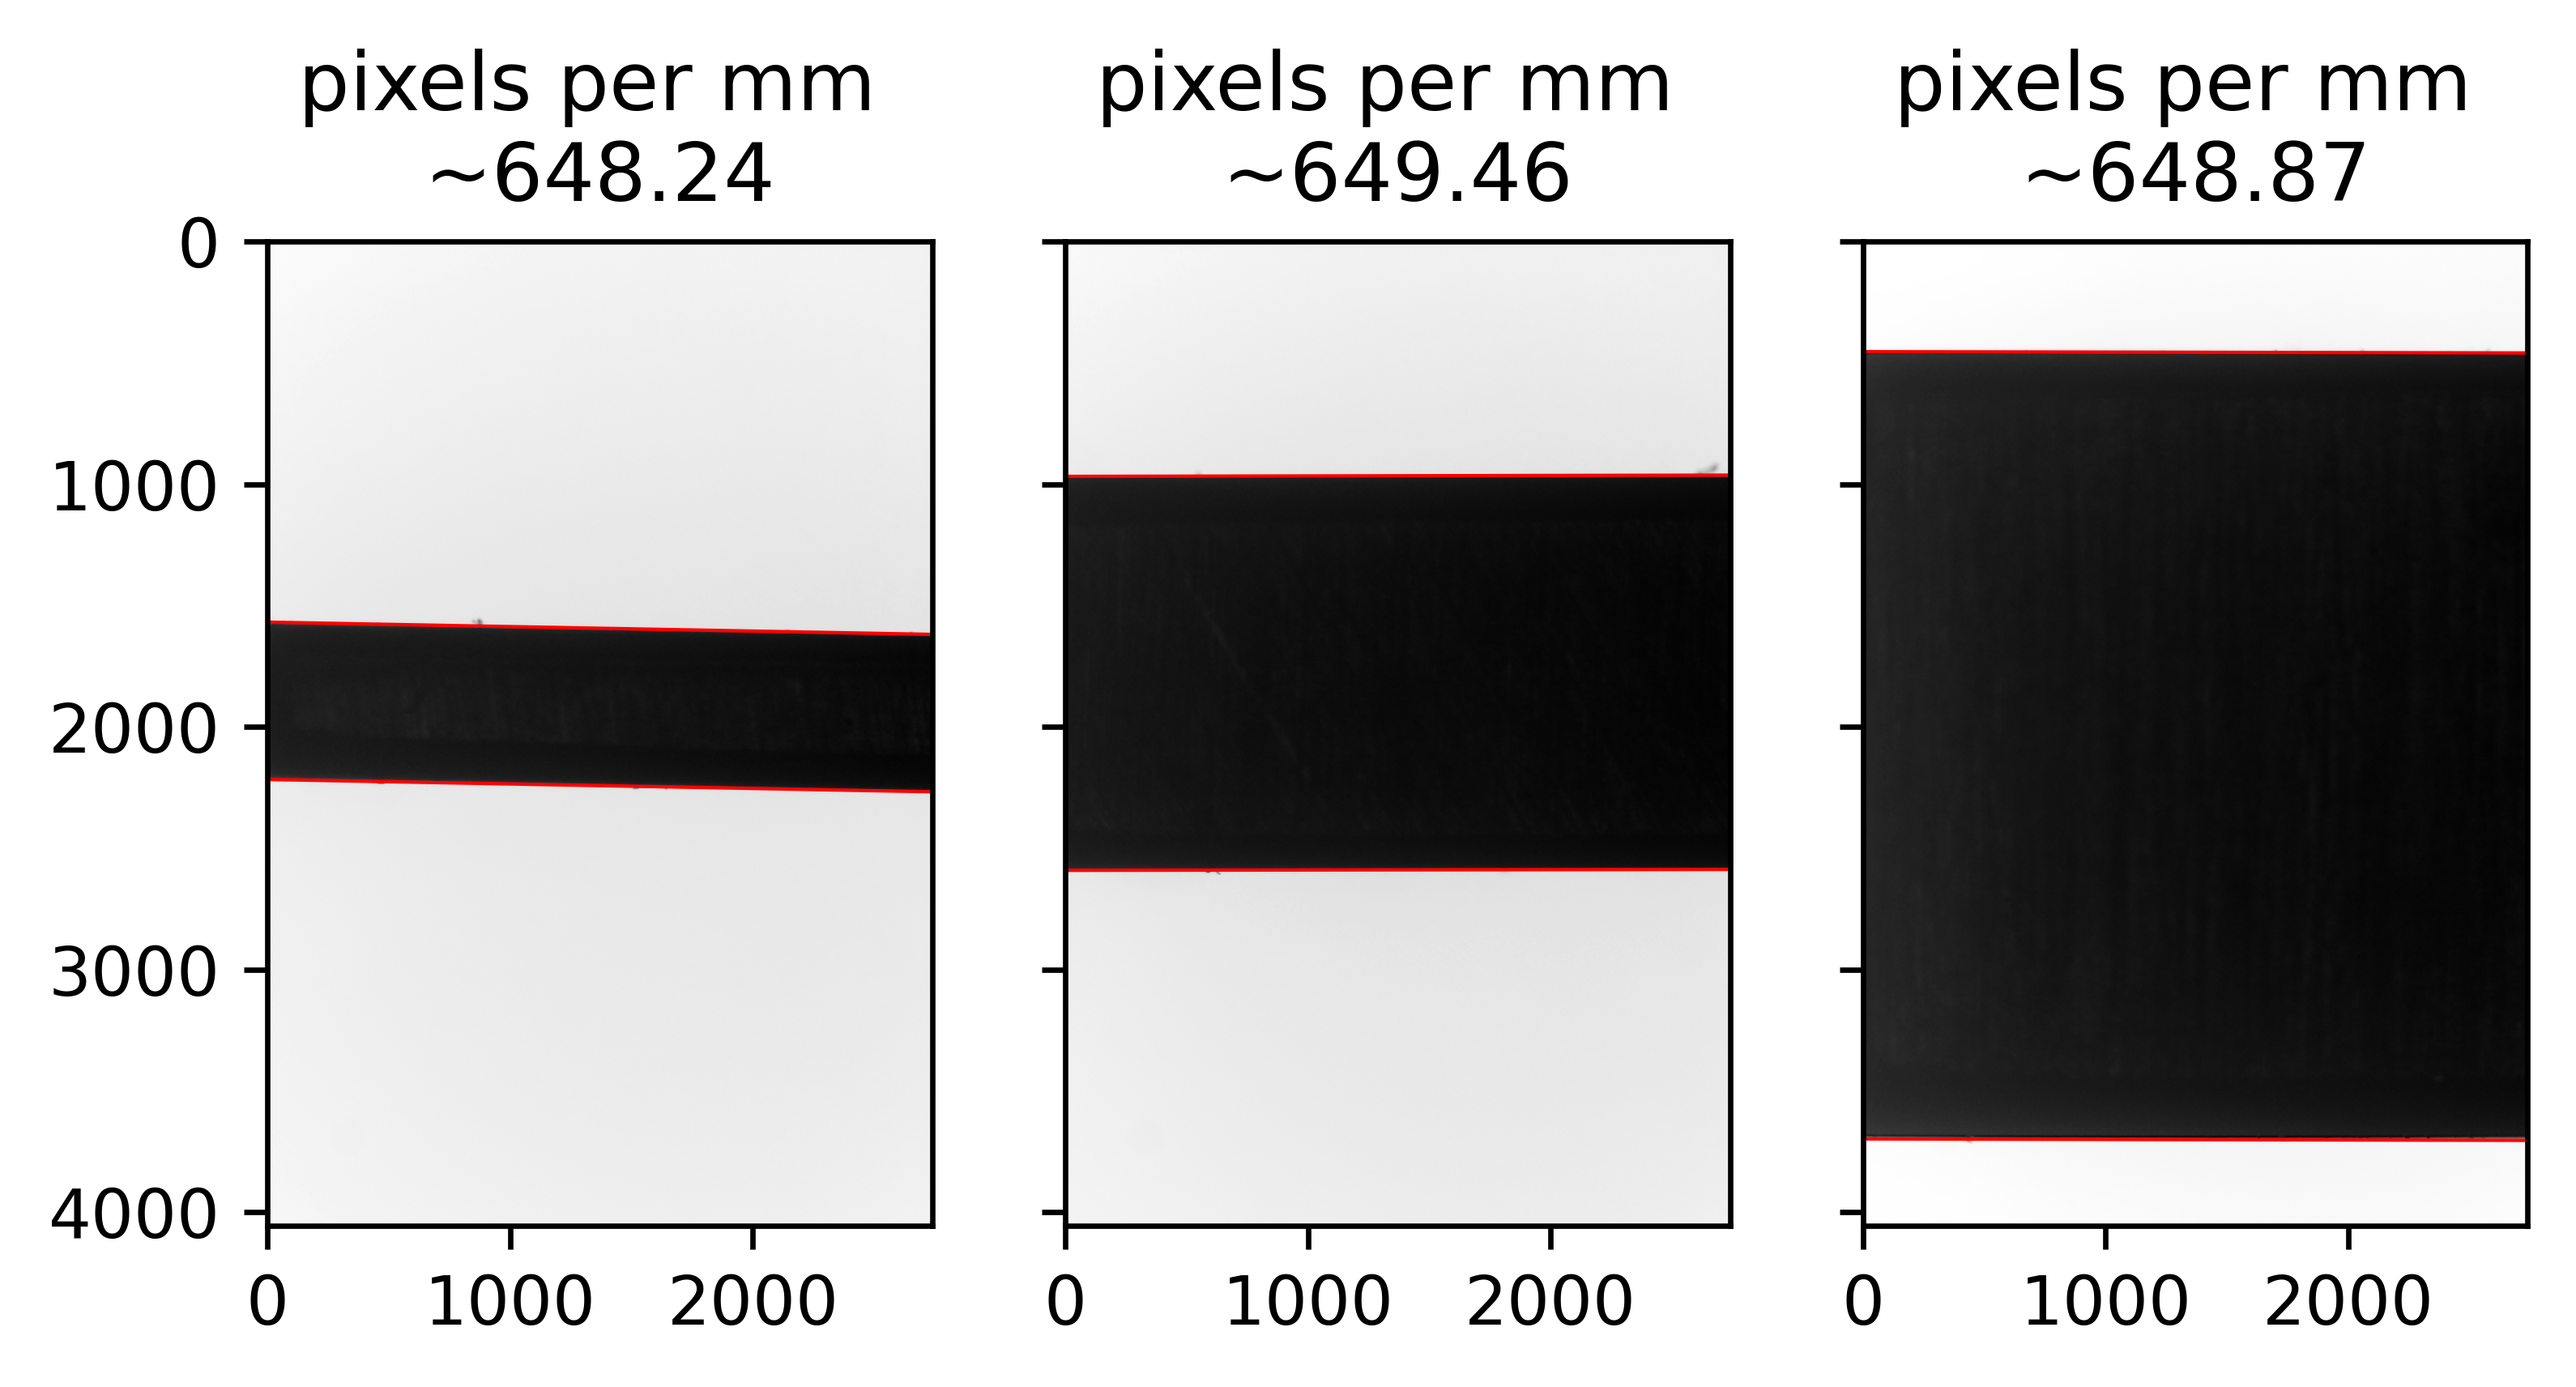

In [140]:
# ========== FIND PIXEL SIZE ==========
# Import packages ...
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import color
import numpy as np

# Create some functions ...
def find_edges(img):
    # Compute im gradient ...
    im_grad = np.gradient(img)[0]
    
    # Get edges from min and max grad ...
    bottom = np.argmax(im_grad, axis = 0)
    top    = np.argmin(im_grad, axis = 0)
    
    return np.c_[bottom, top]
    
def find_separation(edge_coords):
    # Get linear fit coefficients ...
    bottom_coeffs = np.polyfit(range(0, len(edge_coords[:, 0])), edge_coords[:, 0], 1)
    top_coeffs    = np.polyfit(range(0, len(edge_coords[:, 1])), edge_coords[:, 1], 1)
    
    # Find separation of planes ...
    A = (bottom_coeffs[0] + top_coeffs[0])/2
    separation = (bottom_coeffs[1] - top_coeffs[1])/np.sqrt(1 + A**2)
    
    # Generate some fitting points (to check it is correct) ...
    end_points = np.stack(
        [
        np.polyval(bottom_coeffs, [0, len(edge_coords[:, 0]) - 1]),
        np.polyval(top_coeffs   , [0, len(edge_coords[:, 1]) - 1])
        ]
    )
    
    return separation, end_points

# Read images (recolour, flip, and clip too) ...
imgs = [
    color.rgb2gray(mpimg.imread('1mm_gauge.tif')).T[:, 300:], 
    color.rgb2gray(mpimg.imread('2-5mm_gauge.tif')).T[:, 300:], 
    color.rgb2gray(mpimg.imread('5mm_gauge.tif')).T[:, 300:]
]

# Create list of gauge block lengths ...
lengths = [1.0, 2.5, 5.0]

# Initialise fig and empty pix per mm list ...
fig, axes = plt.subplots(ncols = 3, nrows = 1, sharey = True, sharex = True, dpi = 600)
pix_per_mm = []

for index in range(0, 3):
    # Find the top and bottom edges ...
    edges = find_edges(imgs[index])
    
    # Get the edge separation and some end points ...
    sep, ends = find_separation(edges)
    
    pix_per_mm += [sep/lengths[index]]
    
    # Create pretty plot to check fitting ...
    axes[index].imshow(imgs[index], cmap = 'gray')
    axes[index].plot([0, imgs[index].shape[1] - 1], ends[0], 'r-', linewidth = 0.5)
    axes[index].plot([0, imgs[index].shape[1] - 1], ends[1], 'r-', linewidth = 0.5)
    axes[index].set_title("pixels per mm \n~{0:.2f}".format(pix_per_mm[index]))

# Average the pixels per mm measurements ...
av_pix_per_mm = np.mean(pix_per_mm)
print('Average pixels per mm = {0:.2f}'.format(av_pix_per_mm))

fig.savefig("Output\\Fittings.tif")

In [213]:
import os
from PIL import Image, ImageOps
from numpy import asarray
from skimage.measure import label, regionprops, regionprops_table

# Find files ...
droplet_files = [file for file in os.listdir() if 'gauge' not in file and '.tif' in file]

for index in range(0, 4):
    # Import image ...
    droplet_img = ImageOps.grayscale(Image.open(droplet_files[index]))

    # Find and label image regions ...
    img_labels = label(asarray(droplet_img) < 51)
    rg_props = regionprops(img_labels)

    # Sort region props by descending area ...
    rg_props.sort(key = lambda x: x.area, reverse=True)

    # Get droplet centroid ...
    _, y0 = rg_props[0].centroid

    # Crop image ...
    width, height = droplet_img.size
    cropped_img = droplet_img.crop((int(y0 - 1500), height - 1750, int(y0 + 1500), height))

    # Call draw Method to add 2D graphics in an image
    draw_method = ImageDraw.Draw(cropped_img)

    # Add Text to an image
    draw_method.text(((200 + av_pix_per_mm)//2, 150), "1mm", font = ImageFont.truetype("arial.ttf", 75), anchor = "ms")
    draw_method.rectangle([(100, 200), (int(100 + av_pix_per_mm), 250)], fill = "black")

    # Display edited image
    cropped_img.save("Output\\Scale_bar_" + droplet_files[index])